### yellowflag dataset

build a yellowflag dataset across all the oval races

duration distribution analysis. 
+ when it happens (use distance to normalize different races) 
+ how long of the caution laps


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"

## Load Data

In [2]:
import os
os.getcwd()

'/scratch/hpda/indycar/notebook/8.PitStopAnalysis'

In [3]:
#
# parameters
#
#year = '2017'
year = '2018'
#event = 'Toronto'
#https://www.racing-reference.info/season-stats/2018/O/#
events_totalmiles=[256,500,372,268,500,310]
events_laplen = [1.022,2.5,1.5,0.894,2.5,1.25]
events = ['Phoenix','Indy500','Texas','Iowa','Pocono','Gateway']
events_id={key:idx for idx, key in enumerate(events)}
#events = ['Indy500']
#events = ['Phoenix']

In [4]:
# make indy car completed_laps dataset
# car_number, completed_laps, rank, elapsed_time, rank_diff, elapsed_time_diff 
def make_cl_data(dataset):

    # pick up data with valid rank
    rankdata = dataset.rename_axis('MyIdx').sort_values(by=['elapsed_time','MyIdx'], ascending=True)
    rankdata = rankdata.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')

    # resort by car_number, lap
    uni_ds = rankdata.sort_values(by=['car_number', 'completed_laps', 'elapsed_time'], ascending=True)    
    uni_ds = uni_ds.drop(["unique_id", "best_lap", "current_status", "track_status", "lap_status",
                      "laps_behind_leade","laps_behind_prec","overall_rank","pit_stop_count",
                      "last_pitted_lap","start_position","laps_led"], axis=1)
    
    carnumber = set(uni_ds['car_number'])
    print('cars:', carnumber)
    print('#cars=', len(carnumber))
   
    # faster solution , uni_ds already sorted by car_number and lap
    uni_ds['rank_diff'] = uni_ds['rank'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['rank_diff'][mask] = 0
    
    uni_ds['time_diff'] = uni_ds['elapsed_time'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['time_diff'][mask] = 0
    
    df = uni_ds[['car_number','completed_laps','rank','elapsed_time','rank_diff','time_diff']]
    
    return df

def make_lapstatus_data(dataset):
    final_lap = max(dataset.completed_laps)
    total_laps = final_lap + 1

    # get records for the cars that finish the race
    completed_car_numbers= dataset[dataset.completed_laps == final_lap].car_number.values
    completed_car_count = len(completed_car_numbers)

    print('count of completed cars:', completed_car_count)
    print('completed cars:', completed_car_numbers)
    
    #pick up one of them
    onecar = dataset[dataset['car_number']==completed_car_numbers[0]]
    onecar = onecar.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')
    return onecar[['completed_laps','track_status']]
    

In [5]:
def load_data(event, year):
    inputfile = '../data/final/C_'+ event +'-' + year + '-final.csv'
    outputprefix = year +'-' + event + '-'
    dataset = pd.read_csv(inputfile)
    #dataset.info(verbose=True)    
    
    final_lap = max(dataset.completed_laps)
    total_laps = final_lap + 1

    # get records for the cars that finish the race
    completed_car_numbers= dataset[dataset.completed_laps == final_lap].car_number.values
    completed_car_count = len(completed_car_numbers)

    print('count of completed cars:', completed_car_count)
    print('completed cars:', completed_car_numbers)

    #make a copy
    alldata = dataset.copy()
    dataset = dataset[dataset['car_number'].isin(completed_car_numbers)]
    rankdata = alldata.rename_axis('MyIdx').sort_values(by=['elapsed_time','MyIdx'], ascending=True)
    rankdata = rankdata.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')
    
    cldata = make_cl_data(dataset)
    flagdata = make_lapstatus_data(dataset)
    acldata = make_cl_data(alldata)

    return alldata, rankdata, acldata, flagdata

### overall view of laptime scatter plots



In [6]:
def get_cardata(curcarno, ycol='time_diff'):
    car = acldata[acldata['car_number']==curcarno]
    #print(car['time_diff'].describe())
    
    cols=['completed_laps','rank','car_number','lap_status','track_status',
    'pit_stop_count','current_status','start_position']
    colid={key:idx for idx, key in enumerate(cols)}

    cardata = rankdata[rankdata['car_number'] == curcarno]

    carstatus = [[row[0], row[1],row[2],row[3],row[4],row[5],row[6],row[7]] for row in cardata[
        ['completed_laps','rank','car_number','lap_status','track_status',
        'pit_stop_count','current_status','start_position']].values]
    
    x = car['completed_laps'][1:].values
    y = car[ycol][1:].values

    pits=[]
    yellowflags=[]
    lastflag = 'x'
    for row in carstatus:
        lap = int(row[colid['completed_laps']])

        if row[colid['lap_status']]=='P':
            pits.append(lap)

        if row[colid['track_status']]=='Y':
            if lastflag != 'Y':       
                #start
                yellowflags.append(lap)
        else:
            if lastflag == 'Y':       
                #end
                yellowflags.append(lap)        
        lastflag = row[colid['track_status']]

    #pit lap
    pits = np.array(pits)
    #start, end lap
    #
    yellowflags = np.array(yellowflags)
    if (yellowflags.shape[0] % 2)==1:
        print('crash?:carno=', curcarno)
        yellowflags = []
    else:
        yellowflags = np.array(yellowflags).reshape((-1,2))    
    
    return car, x, y, pits, yellowflags

### bulid the dataset

In [7]:
def get_stagedata(TRIM=2):
    """
    input: acldata, rankdata, the whole dataset
    output: stagedata['car_number','stage','start_lap','end_lap','start_rank','end_rank','yellowflag_raised']
    """
    carlist = set(acldata['car_number'])
    data = []
    for curcarno in carlist:
        car = acldata[acldata['car_number']==curcarno]
        #print(car['time_diff'].describe())

        cols=['completed_laps','rank','car_number','lap_status','track_status',
        'pit_stop_count','current_status','start_position']
        colid={key:idx for idx, key in enumerate(cols)}

        cardata = rankdata[rankdata['car_number'] == curcarno]

        carstatus = [[row[0], row[1],row[2],row[3],row[4],row[5],row[6],row[7]] for row in cardata[
            ['completed_laps','rank','car_number','lap_status','track_status',
            'pit_stop_count','current_status','start_position']].values]

        pits=[]
        yellowflags=[]
        lastflag = 'x'
        
        stage = 0
        start_lap = 0
        pit_lap = -1
        pit_in_caution = 0
        yellowflag_raised = 0
        for row in carstatus:
            lap = int(row[colid['completed_laps']])
            
            if lap==0:
                #hex2int
                start_rank = int(row[colid['start_position']], 16)     
            
            if row[colid['track_status']]=='Y':
                yellowflag_raised = 1
                if lastflag != 'Y':       
                    #start
                    yellowflags.append(lap)
            else:
                if lastflag == 'Y':       
                    #end
                    yellowflags.append(lap)        
            lastflag = row[colid['track_status']]
            
            if row[colid['lap_status']]=='P' and row[colid['current_status']]=='Active':
                pits.append(lap)
                end_lap = lap - TRIM
                end_rank = carstatus[end_lap][colid['rank']]
                
                #pit_lap = lap  #current is pit lap
                
                #redefine pit_lap as the previous caution_lap
                #pit_lap = yellowflags[-1]
                #pit_in_caution = 1 if row[colid['track_status']]=='Y' else 0
                if row[colid['track_status']]=='Y':
                    pit_lap = yellowflags[-1]
                    pit_in_caution = 1
                else:
                    pit_lap = lap
                    pit_in_caution = 0
                
                #add one record
                #stagedata['car_number','stage','start_lap','end_lap','start_rank','end_rank','yellowflag_raised']
                data.append([curcarno,stage,start_lap, end_lap, pit_lap, pit_in_caution, 
                             start_rank, end_rank,yellowflag_raised])
                # prepare for the next
                stage += 1
                start_lap = end_lap  # end_lap + 1?
                start_rank = end_rank
                yellowflag_raised = 1 if lastflag=='Y' else 0

        #final
        end_lap = carstatus[-1][colid['completed_laps']]
        end_rank = carstatus[-1][colid['rank']]
        #add one record
        #stagedata['car_number','stage','start_lap','end_lap',pit_lap, pit_in_caution,'start_rank','end_rank']
        #data.append([curcarno,stage,start_lap, end_lap, pit_lap, pit_in_caution, start_rank, end_rank])
        
        #pit lap
        pits = np.array(pits)
        #start, end lap
        #
        yellowflags = np.array(yellowflags)
        if (yellowflags.shape[0] % 2)==1:
            print('crash?:carno=', curcarno)
            yellowflags = []
        else:
            yellowflags = np.array(yellowflags).reshape((-1,2))  
            
    data = np.array(data)
    #['car_number','stage','start_lap','end_lap',pit_lap, pit_in_caution,'start_rank','end_rank']
    df = pd.DataFrame({'car_number': data[:, 0], 'stage': data[:, 1],'start_lap': data[:, 2],
                      'end_lap': data[:, 3], 'pit_lap': data[:, 4], 'pit_in_caution': data[:, 5],
                       'start_rank': data[:, 6],'end_rank': data[:, 7],'yellowflag_raised':data[:,8]})
    return df, data

### events

In [8]:
def extract_stint_features(stagedata):
    """
    input: (alldata, rankdata, acldata, flagdata, stage, data)
    
    lap_distance    ; lap distance for this stint
    start_lap
    caution_distance
    
    eventid
    car_number
    stageid
    
    pit_in_caution; 1/0
    yellowflag_raised ; 1/0
    
    start_position  ; #
    start_rank  ;  #rank
    end_rank
    """
    #eventid = 0
    cols=['lap_distance','start_lap','caution_distance',
             'eventid','car_number','stageid',
             'pit_in_caution', 'yellowflag_raised',
             'start_position', 'start_rank', 'end_rank']
    colid={key:idx for idx, key in enumerate(cols)}
    
    datacols = ['car_number','stage','start_lap','end_lap','pit_lap', 
                'pit_in_caution', 'start_rank','end_rank','yellowflag_raised']
    datacolid={key:idx for idx, key in enumerate(datacols)}
    
    #maintain a <car,lap, (rank, stage)> index 
    idxcols = ['car_number','completed_laps','rank','stageid']
    carindex = {}
    
    stagedf = pd.DataFrame([],columns=cols)
    for event in stagedata.keys():
        
        eventid = events_id[event]
        
        alldata, rankdata, acldata, flagdata, stage, data = stagedata[event]
        carlist = set(acldata['car_number'])
        laplist = set(acldata['completed_laps'])
        totalcars = len(carlist)
        totallaps = len(laplist)

        # init the index
        #carindex[eventid] = np.array((totalcars, totallaps, 2))
        carindex[eventid] = pd.DataFrame([],columns=idxcols)
        
        records = []
        
        laphist = []
        rankhist = []
        rankchghist = []        
        #['car_number','stage','start_lap','end_lap',pit_lap, pit_in_caution, 'start_rank','end_rank']
        for row in data:
            # a new record
            rec={}
            #status, 'start_lap', start a new car
            if row[datacolid['start_lap']] == 0:
                start_position = row[datacolid['start_rank']]
                laphist = []
                rankhist = []
                rankchghist = []
            
            #target 
            rec['lap_distance'] = row[datacolid['end_lap']] - row[datacolid['start_lap']] + 1
            rec['start_lap'] = row[datacolid['start_lap']]
            rec['caution_distance'] = row[datacolid['end_lap']] - row[datacolid['pit_lap']] + 1
            
            #features
            rec['eventid'] = eventid
            rec['car_number'] = row[datacolid['car_number']]
            rec['stageid'] = row[datacolid['stage']]
            
            rec['pit_in_caution'] = row[datacolid['pit_in_caution']]
            rec['yellowflag_raised'] = row[datacolid['yellowflag_raised']]
            
            rec['start_position'] = start_position
            rec['start_rank'] = row[datacolid['start_rank']]
            rec['end_rank'] = row[datacolid['end_rank']]
            
            
            #add one record
            records.append([rec[col] for col in cols])
            
            #update for the new stage
            lapdata = rankdata[(rankdata['car_number']== rec['car_number']) & 
                               (rankdata['completed_laps']>=row[datacolid['start_lap']]) &
                               (rankdata['completed_laps']<row[datacolid['end_lap']])
                              ]
            laphist.append(lapdata)
            rankhist.extend(list(lapdata['rank']))
            rankchghist.append(row[datacolid['end_rank']] - row[datacolid['start_rank']])
            
            # add to index, go through the lapdata
            #or _lap in range(row[datacolid['start_lap']],row[datacolid['end_lap']]):
            for index, row in lapdata.iterrows():
                #carindex[eventid][rec['car_number'], row['completed_laps'], 0] = row['rank']
                #carindex[eventid][rec['car_number'], row['completed_laps'], 1 = rec['stageid']
                laprec = [rec['car_number'], row['completed_laps'], row['rank'],rec['stageid']]
                df = pd.DataFrame([laprec],columns=idxcols)
                carindex[eventid] = pd.concat([carindex[eventid], df], ignore_index=True)
            
          
        # push this event into stage dataframe
        print('event=%s, records=%d'%(event, len(records)))
        df = pd.DataFrame(records,columns=cols)
        stagedf = pd.concat([stagedf, df], ignore_index=True)
        
        #for the next new event
        #eventid += 1
        
    return stagedf, carindex



In [17]:
def extract_yellowflag_features(stagedata):
    """
    input: (alldata, rankdata, acldata, flagdata, stage, data)

    eventid
    yellowflagid
    start_lap
    end_lap
    """
    #eventid = 0
    cols=['eventid','yellowflagid','start_lap','end_lap']
    colid={key:idx for idx, key in enumerate(cols)}
    
    datacols = ['completed_laps','track_status']
    datacolid={key:idx for idx, key in enumerate(datacols)}
    
    stagedf = pd.DataFrame([],columns=cols)
    for event in stagedata.keys():
        
        eventid = events_id[event]
        
        alldata, rankdata, acldata, flagdata, stage, data = stagedata[event]
        carlist = set(acldata['car_number'])
        laplist = set(acldata['completed_laps'])
        totalcars = len(carlist)
        totallaps = len(laplist)

        records = []
        
        data = flagdata.values
        yellowflagid = 0
        start_lap = -1
        end_lap = -1
        for row in data:
            # a new record
            rec={}
            
            if row[datacolid['completed_laps']] == 0:
                continue
                
            if row[datacolid['track_status']] == 'Y':
                if start_lap == -1:
                    start_lap = row[datacolid['completed_laps']]
                end_lap = row[datacolid['completed_laps']]
            else:
                if start_lap != -1:
                    #add new record
                    rec['eventid'] = eventid
                    rec['yellowflagid'] = yellowflagid
                    rec['start_lap'] = start_lap
                    rec['end_lap'] = end_lap
            
                    records.append([rec[col] for col in cols])
                    start_lap  = -1
                    end_lap = -1
                    yellowflagid += 1
            
        # check the final status
        if start_lap != -1:
            #add new record
            rec['eventid'] = eventid
            rec['yellowflagid'] = yellowflagid
            rec['start_lap'] = start_lap
            rec['end_lap'] = end_lap

            records.append([rec[col] for col in cols])
            
        # push this event into stage dataframe
        print('event=%s, records=%d'%(event, len(records)))
        df = pd.DataFrame(records,columns=cols)
        stagedf = pd.concat([stagedf, df], ignore_index=True)
        
    return stagedf

### load data

In [13]:
stagedata = {}
traindata = None
for event in events:
    #alldata, rankdata, acldata, flagdata
    stagedata[event] = load_data(event, year)
    
    alldata, rankdata, acldata, flagdata = stagedata[event]
    carlist = set(acldata['car_number'])
    laplist = set(acldata['completed_laps'])
    print('%s: carno=%d, lapnum=%d'%(event, len(carlist), len(laplist)))
    
    stage, data = get_stagedata(0)
    stagedata[event] = (alldata, rankdata, acldata, flagdata, stage, data)
    
    if traindata is None:
        traindata = data
    else:
        traindata = np.vstack((traindata, data))

count of completed cars: 11
completed cars: [ 1  6 27  9 28  5 20 14 15 22 30]
cars: {1, 5, 6, 9, 14, 15, 20, 22, 27, 28, 30}
#cars= 11
count of completed cars: 11
completed cars: [ 1  6 27  9 28  5 20 14 15 22 30]
cars: {1, 4, 5, 6, 9, 10, 12, 14, 15, 18, 19, 20, 21, 22, 23, 26, 27, 28, 30, 32, 59, 88, 98}
#cars= 23
Phoenix: carno=23, lapnum=251
crash?:carno= 10
crash?:carno= 19
count of completed cars: 18
completed cars: [12 20  9 27 28 22 29  1  6 15 66 98  4 88 25 60 64 23]


/scratch/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/scratch/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


cars: {64, 1, 66, 98, 4, 6, 9, 12, 60, 15, 20, 22, 23, 88, 25, 27, 28, 29}
#cars= 18
count of completed cars: 18
completed cars: [12 20  9 27 28 22 29  1  6 15 66 98  4 88 25 60 64 23]
cars: {1, 3, 4, 6, 7, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 59, 60, 64, 66, 88, 98}
#cars= 33
Indy500: carno=33, lapnum=201
crash?:carno= 3
crash?:carno= 24
crash?:carno= 33
count of completed cars: 9
completed cars: [ 9 22 27  5 28 15 30 18 10]
cars: {5, 9, 10, 15, 18, 22, 27, 28, 30}
#cars= 9
count of completed cars: 9
completed cars: [ 9 22 27  5 28 15 30 18 10]
cars: {1, 3, 4, 5, 6, 7, 9, 10, 12, 14, 15, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 47, 55, 57, 59, 60, 68, 73, 83, 88, 98}
#cars= 32
Texas: carno=32, lapnum=249
crash?:carno= 12
crash?:carno= 19
count of completed cars: 5
completed cars: [ 5 21 30  1  6]
cars: {1, 5, 6, 21, 30}
#cars= 5
count of completed cars: 5
completed cars: [ 5 21 30  1  6]
cars: {1, 4, 5, 6, 9, 10, 12, 14, 15, 18, 19,

In [16]:
stagedata['Indy500'][3].values.shape

(201, 2)

In [18]:
yflagdf = extract_yellowflag_features(stagedata)

event=Phoenix, records=2
event=Indy500, records=7
event=Texas, records=3
event=Iowa, records=2
event=Pocono, records=2
event=Gateway, records=2


In [19]:
yflagdf.to_csv('yellowflag-v0-%s.csv'%year)

In [20]:
yflagdf.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 4 columns):
eventid         18 non-null object
yellowflagid    18 non-null object
start_lap       18 non-null object
end_lap         18 non-null object
dtypes: object(4)
memory usage: 704.0+ bytes


In [21]:
yflagdf.head(10)

,eventid,yellowflagid,start_lap,end_lap
0,0,0,41,49
1,0,0,229,242
2,1,0,48,54
3,1,0,58,62
4,1,0,68,72
5,1,0,139,144
6,1,0,146,152
7,1,0,154,160
8,1,0,188,192
9,2,0,7,13


### pitstop analysis

In [35]:
def get_distance_data(data, event=[]):
    """
    data ; yflagdf
    events_laplen = [1.022,2.5,1.5,0.894,2.5,1.25]
    
    return:
    normal_stint   ; stint without yellow flags
    """
    if event:
        eventid = [events_id[x] for x in event]
        data = data[data['eventid'].isin(eventid)]
        
    yf_laps = data[['eventid','start_lap','end_lap']].to_numpy()
    ret_laplen = [events_laplen[x[0]]*(x[2] - x[1]) for x in yf_laps]
    ret_lap =  [(x[2] - x[1]) for x in yf_laps]
    
    
    return ret_laplen, ret_lap


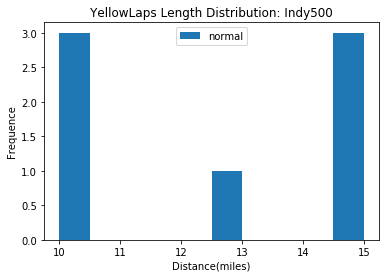

In [36]:
# car 12, will power
yflen, yflaps = get_distance_data(yflagdf,['Indy500'])
plt.hist(yflen,label='normal')
plt.xlabel('Distance(miles)')
plt.ylabel('Frequence')
plt.title('YellowLaps Length Distribution: Indy500')
plt.legend(prop={'size': 10})

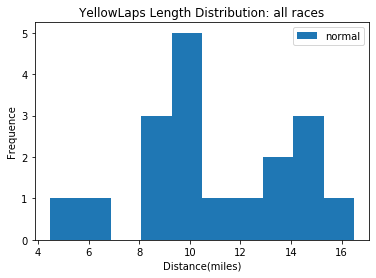

In [41]:
#get all data
yflen2, yflaps2 = get_distance_data(yflagdf)
plt.hist(yflen2,label='normal')
plt.xlabel('Distance(miles)')
plt.ylabel('Frequence')
plt.title('YellowLaps Length Distribution: all races')
plt.legend(prop={'size': 10})

In [38]:
list(yflen2)

[8.176,
 13.286,
 15.0,
 10.0,
 10.0,
 12.5,
 15.0,
 15.0,
 10.0,
 9.0,
 16.5,
 13.5,
 8.94,
 4.47,
 10.0,
 10.0,
 6.25,
 11.25]

In [40]:
list(yflaps2)

[8, 13, 6, 4, 4, 5, 6, 6, 4, 6, 11, 9, 10, 5, 4, 4, 5, 9]

### normalized comparison

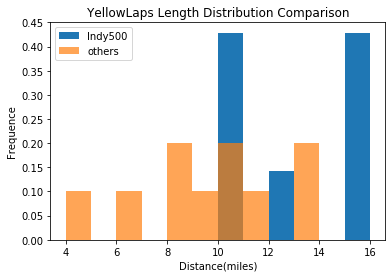

In [51]:
#normalize the comparison
import math
bins = range(math.floor(min(yflen2)),math.ceil(max(yflen2)))
yflen2, yflaps2 = get_distance_data(yflagdf,['Indy500']) 
n, bins, patches = plt.hist(yflen2,bins=bins, label='Indy500', density=True,histtype='stepfilled')

other_events=set(events).difference(set(['Indy500']))
yflen2, yflaps2 = get_distance_data(yflagdf,other_events)  
n2, bins2, patches2 = plt.hist(yflen2,bins=bins,label='others', alpha=0.7,density=True,histtype='stepfilled')
plt.xlabel('Distance(miles)')
plt.ylabel('Frequence')
plt.title('YellowLaps Length Distribution Comparison')
plt.legend(prop={'size': 10},loc="upper left")

### conclusion

